In [1]:
%cd ..

c:\Projects\Groningen-Waste-Collection


# Managerial insights

In [2]:
import glob
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

In [3]:
# For final compilation
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "Computer Modern Serif"

## Helpers

In [4]:
def load(files: list[str]) -> pd.DataFrame:
    data = []
    for file in files:
        with open(file, "r") as fh:
            data.append(json.load(fh))
    
    df = pd.DataFrame(data)
    df["avg_route_duration"] = pd.to_timedelta(df["avg_route_duration"])
    df["experiment"] = range(1, len(files) + 1)

    num_routes_day = df["avg_num_routes_per_day"]
    df["avg_distance"] = df["avg_route_distance"] * num_routes_day
    df["avg_clusters"] = df["avg_route_clusters"] * num_routes_day
    df["avg_stops"] = df["avg_route_stops"] * num_routes_day

    return df

In [5]:
def report(df: pd.DataFrame):
    duration = df.avg_route_duration.mean() / np.timedelta64(1, "h")
    avg_sl = df.avg_service_level.mean()
    print(f"Avg distance      : {df.avg_distance.mean() / 1_000:.1f} km")
    print(f"Avg duration      : {duration:.1f} hours")
    print(f"Avg service level : {100 * avg_sl:.1f}%")
    print(f"Avg excess volume : {df.avg_excess_volume.mean():.1f} litres")
    print(f"Avg clusters      : {df.avg_clusters.mean():.1f}")
    print(f"Avg #routes       : {df.avg_num_routes_per_day.mean():.1f}")
    print(f"Max #unserved     : {df.num_unserved_containers.max()}")
    print(f"Avg fill rate     : {100 * df.avg_fill_factor.mean():.1f}%")

## Tuning

Tuning $\rho$ and $\epsilon$.

In [6]:
tune = load([f"out/tuning/prize_{idx}.json" for idx in range(1, 89)])
tune["rho"] = np.repeat(1000 * 2 ** np.arange(8), 11)
tune["epsilon"] = 1 - np.tile(np.linspace(0.9, 1.0, num=11), 8)

In [7]:
tune.pivot(index="epsilon", columns="rho", values="avg_distance")

rho,1000,2000,4000,8000,16000,32000,64000,128000
epsilon,,,,,,,,
0.00,78621.517711,98523.907357,109755.130790,120897.953678,129501.926431,134560.177112,138481.825613,139527.822888
0.01,111402.092643,115535.356948,120264.752044,124241.084469,129467.168937,134401.580381,139214.247956,143108.435967
0.02,112604.752044,116311.675749,119922.057221,124806.991826,130260.188011,134157.920981,138840.073569,140010.997275
0.03,113584.348774,117473.686649,120791.373297,124635.989101,129268.468665,134368.310627,137974.509537,140049.321526
0.04,114524.877384,117657.182561,120505.555858,124233.918256,130287.828338,133654.861035,138937.299728,139740.645777
0.05,114405.335150,117878.506812,120564.893733,124527.727520,130099.204360,133806.446866,137750.419619,140089.490463
0.06,115195.376022,118274.493188,121451.599455,126615.425068,130403.269755,134487.065395,137160.972752,139253.318801
0.07,115909.343324,118682.850136,122118.365123,125103.940054,129894.689373,134267.547684,137105.773842,139835.861035
0.08,115545.482289,118804.138965,122022.610354,125865.160763,130696.149864,133869.190736,137390.741144,141050.705722


In [8]:
tune.pivot(index="epsilon", columns="rho", values="avg_service_level")

rho,1000,2000,4000,8000,16000,32000,64000,128000
epsilon,,,,,,,,
0.00,0.767297,0.905089,0.949112,0.971550,0.983066,0.989711,0.993198,0.995414
0.01,0.798426,0.902262,0.948045,0.970571,0.982931,0.990205,0.992929,0.995593
0.02,0.802288,0.904945,0.949843,0.970249,0.984270,0.989800,0.993727,0.995509
0.03,0.806891,0.904681,0.948437,0.970501,0.983632,0.989615,0.993419,0.995833
0.04,0.808433,0.905280,0.950183,0.971178,0.982834,0.990294,0.993432,0.995375
0.05,0.816850,0.904040,0.950918,0.970730,0.982806,0.989279,0.993134,0.996114
0.06,0.812650,0.908051,0.949724,0.970049,0.983528,0.989179,0.993321,0.995190
0.07,0.813343,0.908833,0.951717,0.971307,0.982239,0.989078,0.993928,0.996084
0.08,0.817795,0.909613,0.949297,0.972040,0.983336,0.989724,0.994035,0.995362


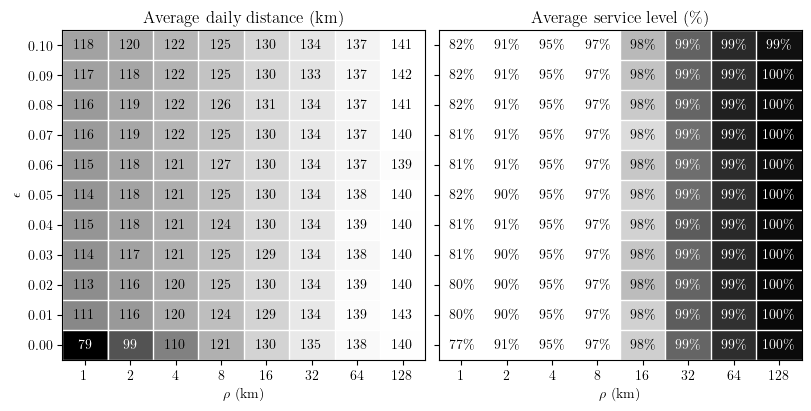

In [9]:
avg_distance = tune.pivot(
    index="epsilon",
    columns="rho",
    values="avg_distance",
).to_numpy()

avg_service_level = tune.pivot(
    index="epsilon",
    columns="rho",
    values="avg_service_level",
).to_numpy()

rhos = sorted(tune.rho.unique() // 1_000)
epsilons = sorted(tune.epsilon.unique())

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharey=True,
    layout="constrained",
)


def make_plot(ax, data, **kwargs):
    ax.imshow(data, origin="lower", aspect="auto", **kwargs)

    ax.set_xticks(np.arange(len(rhos)), labels=rhos)
    ax.set_yticks(np.arange(len(epsilons)), labels=map("{:.2f}".format, epsilons))

    ax.set_xticks(np.arange(len(rhos)) - .5, minor=True)
    ax.set_yticks(np.arange(len(epsilons) + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)


make_plot(ax1, avg_distance, vmax=140_000, cmap="gray")
make_plot(ax2, avg_service_level, vmin=0.98, cmap="gray_r")

for i in range(len(epsilons)):
    for j in range(len(rhos)):
        ax1.text(
            j,
            i,
            "{:.0f}".format(avg_distance[i, j] / 1_000),
            ha="center",
            va="center", 
            c="white" if avg_distance[i, j] / 1_000 < 100 else "black",
        )

        ax2.text(
            j,
            i,
            "{:.0f}\%".format(100 * avg_service_level[i, j]),
            ha="center",
            va="center",
            c="white" if avg_service_level[i, j] >= 0.985 else "black",
        )

ax1.set_ylabel("$\epsilon$")
ax1.set_xlabel("$\\rho$ (km)")
ax2.set_xlabel("$\\rho$ (km)")

ax1.set_title("Average daily distance (km)")
ax2.set_title("Average service level (\%)")

plt.savefig("out/case_tuning.pdf", transparent=True)

## Results

Results on various different instance sets.

In [10]:
baseline3 = load(sorted(glob.glob("out/results/baseline3_*.json")))
baseline200 = load(sorted(glob.glob("out/results/baseline200*.json")))
baseline250 = load(sorted(glob.glob("out/results/baseline250_*.json")))

In [11]:
prize3 = load(sorted(glob.glob("out/results/prize3_*.json")))
prize4 = load(sorted(glob.glob("out/results/prize4_*.json")))

prize_5K = load(sorted(glob.glob("out/results/prize5K_*.json")))
prize_10K = load(sorted(glob.glob("out/results/prize10K_*.json")))
prize_20K = load(sorted(glob.glob("out/results/prize20K_*.json")))

### Basic statistics

First we consider some basic statistics about the overall route planning.
This includes average route duration, number of vehicles used, number of stops in a day, etc.

In [12]:
report(baseline3)  # 3 vehicles, 148 clusters

Avg distance      : 170.1 km
Avg duration      : 5.6 hours
Avg service level : 96.4%
Avg excess volume : 2350.8 litres
Avg clusters      : 148.0
Avg #routes       : 3.0
Max #unserved     : 166
Avg fill rate     : 68.8%


In [13]:
report(baseline200)  # 3 vehicles, 200 clusters

Avg distance      : 215.7 km
Avg duration      : 7.5 hours
Avg service level : 99.5%
Avg excess volume : 1101.3 litres
Avg clusters      : 200.0
Avg #routes       : 3.0
Max #unserved     : 5
Avg fill rate     : 61.2%


In [14]:
report(baseline250)  # regular baseline: 4 vehicles, 250 clusters

Avg distance      : 251.3 km
Avg duration      : 6.8 hours
Avg service level : 99.9%
Avg excess volume : 1591.7 litres
Avg clusters      : 250.0
Avg #routes       : 4.0
Max #unserved     : 5
Avg fill rate     : 48.9%


In [15]:
report(prize3)  # prize-collecting, 3 vehicles

Avg distance      : 151.0 km
Avg duration      : 5.4 hours
Avg service level : 99.2%
Avg excess volume : 110.5 litres
Avg clusters      : 147.4
Avg #routes       : 3.0
Max #unserved     : 4
Avg fill rate     : 83.0%


In [16]:
report(prize4)  # regular prize-collecting, 4 vehicles

Avg distance      : 139.8 km
Avg duration      : 3.7 hours
Avg service level : 99.6%
Avg excess volume : 91.9 litres
Avg clusters      : 148.6
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 82.3%


In [17]:
report(prize_5K)  # regular prize-collecting, with rho = 5_000

Avg distance      : 113.9 km
Avg duration      : 3.2 hours
Avg service level : 95.6%
Avg excess volume : 419.8 litres
Avg clusters      : 139.9
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 87.4%


In [18]:
report(prize_10K)  # regular prize-collecting, with rho = 10_000

Avg distance      : 125.3 km
Avg duration      : 3.4 hours
Avg service level : 97.5%
Avg excess volume : 158.9 litres
Avg clusters      : 142.3
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 85.9%


In [19]:
report(prize_20K)  # regular prize-collecting, with rho = 20_000

Avg distance      : 132.0 km
Avg duration      : 3.5 hours
Avg service level : 98.6%
Avg excess volume : 116.1 litres
Avg clusters      : 144.2
Avg #routes       : 4.0
Max #unserved     : 4
Avg fill rate     : 84.8%


### Average distance vs. service level

The figure below compares average distance traveled per day (the total distance of all routes on a day) against the average service level that's achieved by a strategy.
Typically, as the distance increases, the service level should go up: more containers are visited, etc.
The key is to balance the two.

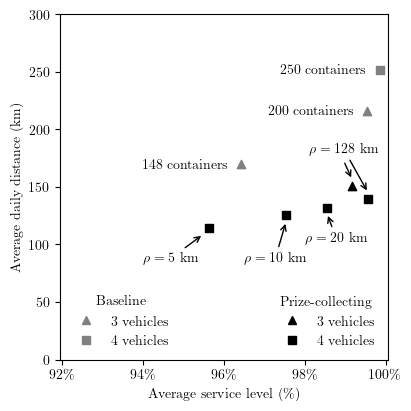

In [20]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")

for idx, (data, marker) in enumerate(zip(
    [baseline3, baseline200, baseline250],
    ["^", "^", "s"],
)):
    ax.scatter(
        x=[data.avg_service_level.mean()],
        y=[data.avg_distance.mean()],
        marker=marker,
        c="gray",
    )

for idx, (data, marker) in enumerate(zip(
    [prize3, prize4, prize_5K, prize_10K, prize_20K],
    ["^", "s", "s", "s", "s"],
)):
    ax.scatter(
        x=[data.avg_service_level.mean()],
        y=[data.avg_distance.mean()],
        marker=marker,
        c="black",
    )

ticks = mtick.FuncFormatter(lambda x, _: "{0:g}".format(x / 1_000))
ax.yaxis.set_major_formatter(ticks)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_xlim([0.92 - 0.0005, 1 + 0.0005])
ax.set_ylim([0, 300_000])

legend1 = plt.legend(
    [
        Line2D([0], [0], color="gray", marker="^", linestyle=""),
        Line2D([0], [0], color="grey", marker="s", linestyle=""),
    ],
    ["3 vehicles", "4 vehicles"],
    frameon=False,
    title="Baseline",
    loc="lower left",
)

legend2 = plt.legend(
    [
        Line2D([0], [0], color="black", marker="^", linestyle=""),
        Line2D([0], [0], color="black", marker="s", linestyle=""),
    ],
    ["3 vehicles", "4 vehicles"],
    frameon=False,
    title="Prize-collecting",
    loc="lower right",
)

plt.gca().add_artist(legend1)

ax.set_xlabel("Average service level (\%)")
ax.set_ylabel("Average daily distance (km)")

# Labels explaining some of the data points in more detail. Some manual
# offsetting is needed to make this look nice.
ax.text(0.94, 165_000, "148 containers")
ax.text(0.971, 212_500, "200 containers")
ax.text(0.974, 247_500, "250 containers")

xy = (
    prize_5K.avg_service_level.mean() - 0.00125,
    prize_5K.avg_distance.mean() - 5_000
)
ax.annotate("$\\rho = 5$ km", xy, xytext=(0.94, 85_000),
            arrowprops=dict(arrowstyle="->"))

xy = (
    prize_10K.avg_service_level.mean(),
    prize_10K.avg_distance.mean() - 5_000
)
ax.annotate("$\\rho = 10$ km", xy, xytext=(0.965, 85_000),
            arrowprops=dict(arrowstyle="->"))

xy = (
    prize_20K.avg_service_level.mean(),
    prize_20K.avg_distance.mean() - 5_000
)
ax.annotate("$\\rho = 20$ km", xy, xytext=(0.98, 102_500),
            arrowprops=dict(arrowstyle="->"))

xy = (
    prize4.avg_service_level.mean(),
    prize4.avg_distance.mean() + 5_000
)
ax.annotate("$\\rho = 128$ km", xy, xytext=(0.981, 180_000),
            arrowprops=dict(arrowstyle="->"))

xy = (
    prize3.avg_service_level.mean(),
    prize3.avg_distance.mean() + 5_000
)
ax.annotate("$\\rho = 128$ km", xy, xytext=(0.98, 177_500), alpha=0.0,
            arrowprops=dict(arrowstyle="->"))

plt.savefig("out/baseline_vs_prize.pdf", transparent=True)

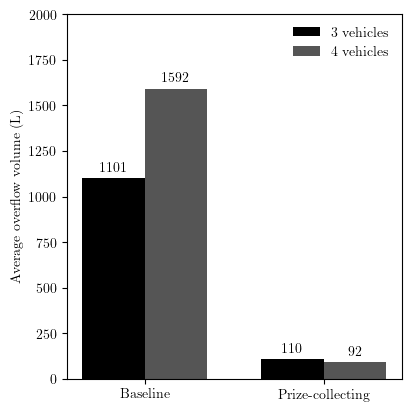

In [21]:
policies = ("Baseline", "Prize-collecting")
data = {
    "3 vehicles": (baseline200, prize3),
    "4 vehicles": (baseline250, prize4),
}

x = np.arange(len(policies))
width = 0.35
multiplier = 0

fig, ax = plt.subplots(layout="constrained", figsize=(4, 4))

colors = plt.get_cmap("gray")
colors = colors([0, 1/3])

for (attr, (base, prize)), color in zip(data.items(), colors):
    measurement = (
        base.avg_excess_volume.mean(),
        prize.avg_excess_volume.mean(),
    )
    offset = width * (multiplier + 0.5)
    rects = ax.bar(x + offset, measurement, width, label=attr, color=color)
    ax.bar_label(rects, fmt="{:.0f}", padding=3)
    multiplier += 1

ax.set_ylabel("Average overflow volume (L)")
ax.set_xticks(x + width, policies)
ax.legend(loc="upper right", frameon=False)
ax.set_ylim(0, 2_000)

plt.savefig("out/avg_overflow_volume.pdf", transparent=True)